In [1]:
import sys  
sys.path.insert(0, './machine_learning_models')

from logistic_regression import logistic_regression
from stochastic_gradient_descent import stochastic_gradient_descent
from knn import knn
from kernel_svm import kernel_svm
from naive_bayes import naive_bayes
from random_forest import random_forest
from voting_classifier import voting_classifier
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import model_from_json
import pickle
import dill

In [2]:
min_threshold = 1.75
max_threshold = 3

In [3]:
def plot_chart(title, x_label, y_label):
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show()

In [4]:
def plot_hist(title, x_label, y_label, data):
    plt.hist(data, density=False, bins=20)  # density=False would make counts
    plot_chart(title, x_label, y_label)
    
def plot_bar(title, x_label, y_label, x_data, y_data):
    ax= plt.subplot()
    plt.bar(x_data, y_data) 
    # plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.xticks(fontsize=10, rotation=90)
    plot_chart(title, x_label, y_label)
    
def plot_pie_chart(title, labels, data):
    data_converted = np.unique(data, return_counts=True)[1]
    plt.pie(data_converted, labels = labels, startangle = 90, shadow = True, autopct='%.2f%%')
    plt.title(title)
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show() 
    

In [5]:
def check_bet_worth(prediction, odds_a, odds_b, pred_odds_a, pred_odds_b):
    return (prediction == 1 and (pred_odds_a < odds_a) and (game['ODDS_A'] > min_threshold and game['ODDS_A'] < max_threshold)) or (prediction == 0 and (pred_odds_b < odds_b) and (game['ODDS_B'] > min_threshold and game['ODDS_B'] < max_threshold))
#     return (prediction == 1 and (game['ODDS_A'] > min_threshold and game['ODDS_A'] < max_threshold)) or (prediction == 0 and (game['ODDS_B'] > min_threshold and game['ODDS_B'] < max_threshold))

In [6]:
def check_game_with_odds(game, bet_value, pred_odds_a, pred_odds_b):
    game_money = 0
    prediction = game['ODDS_A'] <= game['ODDS_B']
    if check_bet_worth(prediction, game['ODDS_A'], game['ODDS_B'], pred_odds_a, pred_odds_b):
        if game['WINNER'] == prediction and game['WINNER'] == 1:
            game_money = (bet_value*game['ODDS_A'] - bet_value)
        elif game['WINNER'] == prediction and game['WINNER'] == 0:
            game_money = (bet_value*game['ODDS_B'] - bet_value)
        else:
            game_money = -bet_value
    return game_money

In [7]:
def check_model_performance_on_game(game, prediction, bet_value, pred_odds_a, pred_odds_b):
    game_money = 0
    if check_bet_worth(prediction, game['ODDS_A'], game['ODDS_B'], pred_odds_a, pred_odds_b):
        if game['WINNER'] == prediction and game['WINNER'] == 1:
            game_money = (bet_value*game['ODDS_A'] - bet_value)
        elif game['WINNER'] == prediction and game['WINNER'] == 0:
            game_money = (bet_value*game['ODDS_B'] - bet_value)
        else:
            game_money = -bet_value
    return game_money

In [829]:
def get_bet_value(prob):
#     bet_value = 0 
#     if prob >= 0.5:
#         bet_value = 10*prob
#     else:
#         bet_value = 10*abs(1-prob)
    bet_value = 10
    return bet_value
    

In [830]:
season_file = '2008-2021'

first_season_train = 20000 + 2012
last_season_train = 20000 + 2020
season = "{}-{}".format(first_season_train - 20000, last_season_train - 20000)

first_season_test = 20000 + 2021
last_season_test = 20000 + 2021
season_test = "{}-{}".format(first_season_test - 20000, last_season_test - 20000)
results = []

print('\nGetting data for the model...')

whole_dataset = pd.read_csv('./data/{}.csv'.format(season_file))

dataset_train = whole_dataset.loc[(whole_dataset['SEASON_ID'] >= first_season_train) & (whole_dataset['SEASON_ID'] <= last_season_train)].reset_index(drop=True)
dataset = whole_dataset.loc[(whole_dataset['SEASON_ID'] >= first_season_test) & (whole_dataset['SEASON_ID'] <= last_season_test)].reset_index(drop=True)

X = dataset.iloc[:, 5:-1].values
y = dataset.iloc[:, -1].values


Getting data for the model...


In [831]:
dataset_train.head()

,Unnamed: 0,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,FT_PCT_A,...,FG_PCT_B,FG3_PCT_B,FT_PCT_B,REB_B,TOV_B,SEASON_B_PCT,PER_B,ODDS_B,ELO_B,WINNER
0,4281,22012,2012-11-09,LAL,GSW,97.2,98.8,0.4702,0.3484,0.6604,...,0.4514,0.3216,0.7432,43.0,16.2,0.6,15.749837,3.82,1432.370801,1
1,4282,22012,2012-11-09,PHX,CLE,97.4,105.0,0.4248,0.2824,0.7072,...,0.4370,0.3904,0.6154,42.2,17.8,0.4,16.483415,2.33,1369.393675,1
2,4283,22012,2012-11-09,SAC,SAS,92.8,97.2,0.4146,0.3108,0.7744,...,0.4736,0.3786,0.7362,37.8,15.0,0.8,15.464797,1.41,1661.442375,0
3,4284,22012,2012-11-09,DEN,UTA,96.4,97.8,0.4338,0.2902,0.6232,...,0.4446,0.3596,0.7366,43.2,14.6,0.4,17.402349,2.94,1547.534485,1
4,4285,22012,2012-11-09,OKC,DET,98.0,92.2,0.4642,0.4244,0.8518,...,0.4300,0.3710,0.7512,35.2,15.0,0.0,10.446004,7.46,1401.452196,1


In [832]:
dataset_train.tail()

,Unnamed: 0,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,FT_PCT_A,...,FG_PCT_B,FG3_PCT_B,FT_PCT_B,REB_B,TOV_B,SEASON_B_PCT,PER_B,ODDS_B,ELO_B,WINNER
10034,14315,22020,2021-05-16,MIN,DAL,118.6,115.9,0.4623,0.3358,0.7023,...,0.4762,0.3702,0.8101,41.8,11.8,0.591549,22.370110,1.37,1581.329604,1
10035,14316,22020,2021-05-16,WAS,CHA,127.4,121.2,0.4938,0.3705,0.8120,...,0.4406,0.3332,0.6981,45.4,13.0,0.464789,19.021417,3.28,1437.083206,1
10036,14317,22020,2021-05-16,TOR,IND,107.3,114.5,0.4408,0.3577,0.7316,...,0.5031,0.3947,0.8224,43.8,14.0,0.464789,21.342337,1.42,1477.631814,0
10037,14318,22020,2021-05-16,OKC,LAC,101.9,121.3,0.4148,0.3143,0.7156,...,0.4748,0.3791,0.8720,43.8,15.6,0.661972,9.889166,1.30,1633.250416,1
10038,14319,22020,2021-05-16,NOP,LAL,113.5,115.5,0.4483,0.3227,0.7034,...,0.4611,0.3592,0.7020,43.4,14.8,0.577465,21.743538,1.22,1547.269577,0


In [833]:
dataset.head()

,Unnamed: 0,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,FT_PCT_A,...,FG_PCT_B,FG3_PCT_B,FT_PCT_B,REB_B,TOV_B,SEASON_B_PCT,PER_B,ODDS_B,ELO_B,WINNER
0,14320,22021,2021-10-29,TOR,ORL,103.8,99.0,0.4142,0.3312,0.7710,...,0.4220,0.3264,0.7632,43.8,17.0,0.2,16.510804,4.41,1332.194467,1
1,14321,22021,2021-10-29,BKN,IND,102.0,108.6,0.4314,0.3432,0.7968,...,0.4640,0.3586,0.8186,47.0,17.4,0.2,13.474423,4.24,1474.327643,1
2,14322,22021,2021-10-29,LAL,CLE,116.0,119.6,0.4762,0.3824,0.7090,...,0.4606,0.2676,0.7930,46.4,15.4,0.6,16.884168,3.84,1411.865201,1
3,14323,22021,2021-10-30,MEM,MIA,114.0,114.6,0.4428,0.3604,0.8294,...,0.4512,0.2914,0.8696,55.4,15.4,0.8,15.598563,2.40,1587.938377,0
4,14324,22021,2021-10-30,WAS,BOS,112.2,107.8,0.4578,0.3316,0.8078,...,0.4344,0.3472,0.7854,46.2,16.0,0.4,17.809523,2.11,1478.003335,1


In [834]:
dataset.tail()

,Unnamed: 0,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,FT_PCT_A,...,FG_PCT_B,FG3_PCT_B,FT_PCT_B,REB_B,TOV_B,SEASON_B_PCT,PER_B,ODDS_B,ELO_B,WINNER
1070,15390,22021,2022-03-31,BKN,MIL,121.2,112.6,0.5237,0.3798,0.7895,...,0.4906,0.3968,0.7763,47.0,12.4,0.626667,23.055373,2.11,1595.500332,0
1071,15391,22021,2022-03-31,CHI,LAC,104.5,110.5,0.4579,0.3366,0.7892,...,0.4460,0.3580,0.8492,40.4,11.3,0.486842,15.013892,2.19,1457.263541,1
1072,15392,22021,2022-04-01,ORL,TOR,106.7,115.1,0.4308,0.3353,0.7879,...,0.4669,0.3439,0.7544,48.9,11.1,0.578947,19.125894,1.15,1590.587084,0
1073,15393,22021,2022-04-01,WAS,DAL,108.8,113.0,0.4760,0.3362,0.7769,...,0.4759,0.3596,0.7911,42.6,12.2,0.623377,16.388047,1.31,1597.770789,1
1074,15394,22021,2022-04-01,BOS,IND,116.7,104.0,0.4938,0.3767,0.8405,...,0.4735,0.3513,0.8154,39.9,13.8,0.324675,21.257967,9.97,1387.649305,1


In [835]:
directory = "models/{}".format(season)
if not os.path.exists(directory):
    os.makedirs(directory)

In [836]:
print('\nExecuting the logistic Regression model...')
Pkl_Filename = "{}/LogisticRegressionModel.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        logisticRegression = pickle.load(file)
except:
    logisticRegression = logistic_regression(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(logisticRegression, file)
results.append(dict(model='Logistic Regression',cm=logisticRegression[0], acc=logisticRegression[1], classifier=logisticRegression[2]))



Executing the logistic Regression model...


In [837]:
print('\nExecuting the Stochastic Gradient Descent model...')
Pkl_Filename = "{}/StochasticGradientDescent.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        sgd = pickle.load(file)
except:
    sgd = stochastic_gradient_descent(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(sgd, file)
results.append(dict(model='Stochastic Gradient Descent',cm=sgd[0], acc=sgd[1], classifier=sgd[2]))



Executing the Stochastic Gradient Descent model...


In [838]:
print('\nExecuting the KNN model...')
Pkl_Filename = "{}/KNN.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        knn_model = pickle.load(file)
except:
    knn_model = knn(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(knn_model, file)
results.append(dict(model='KNN',cm=knn_model[0], acc=knn_model[1], classifier=knn_model[2]))



Executing the KNN model...


In [839]:
print('Executing the Kernel SVM model...')
Pkl_Filename = "{}/KernelSVM.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        svm = pickle.load(file)
except:
    svm = kernel_svm(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(svm, file)
results.append(dict(model='Kernel SVM',cm=svm[0], acc=svm[1], classifier=svm[2]))

Executing the Kernel SVM model...


In [840]:
print('Executing the Naive Bayes model...')
Pkl_Filename = "{}/NaiveBayes.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        nb = pickle.load(file)
except:
    nb = naive_bayes(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(nb, file)
results.append(dict(model='Naive Bayes',cm=nb[0], acc=nb[1], classifier=nb[2]))

Executing the Naive Bayes model...


In [841]:
print('Executing the Random Forest model...')
Pkl_Filename = "{}/RandomForest.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        rf = pickle.load(file)
except:
    rf = random_forest(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(rf, file)
results.append(dict(model='Random Forest',cm=rf[0], acc=rf[1], classifier=rf[2]))

Executing the Random Forest model...


In [842]:
print('Executing the Voting Classifier model...')
Pkl_Filename = "{}/VotingClassifier.pkl".format(directory)

estimators = [('lr', logisticRegression[2]), ('svm', svm[2]), ('nb', nb[2]), ('sgd', sgd[2])]
weights = [1,1,1,1]

try:
    with open(Pkl_Filename, 'rb') as file:  
        vc = pickle.load(file)
except:
    vc = voting_classifier(dataset, estimators, weights)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(vc, file)
results.append(dict(model='Voting Classifier',cm=vc[0], acc=vc[1], classifier=vc[2]))

Executing the Voting Classifier model...



Getting the feature correlation matrix...


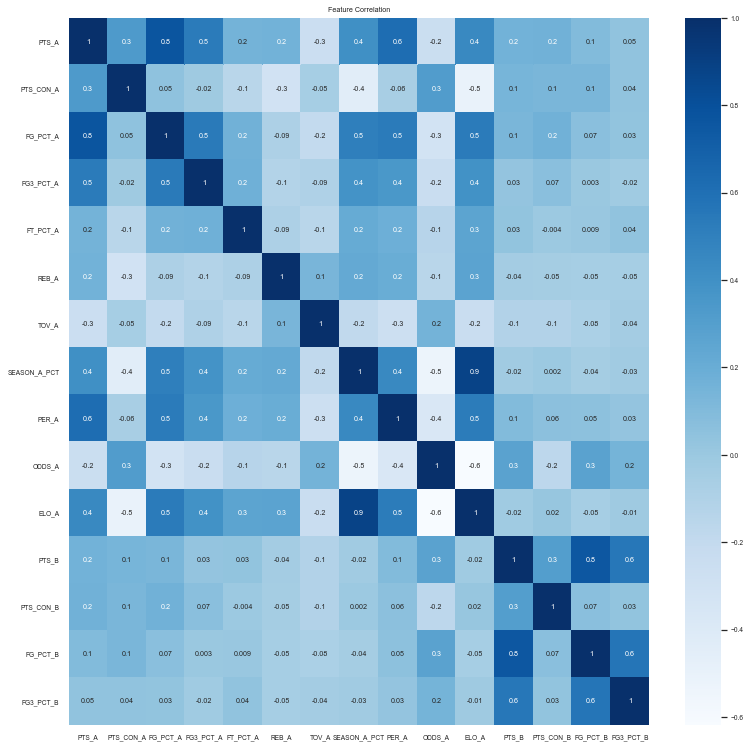

In [843]:
print('\nGetting the feature correlation matrix...')

import seaborn as sns

try:
    dependent_variables = dataset.iloc[:,5:20]
    corrmat = dependent_variables.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(13,13))
    title = 'Feature Correlation'
    plt.title(title)
    #plot heat map
    sns.set(font_scale=0.6)
    g=sns.heatmap(dependent_variables.corr(),annot=True,cmap='Blues', fmt='0.1g')
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show()
except:
    print('No correlation matrix for the selected model.')

In [844]:
print('\nGetting classification model with the best predictions...')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_transformed = sc.fit_transform(X)

modelCont = 0
highestAcc = 0
probs = dict()
total_invested = dict()
while True:
    try:
        total_invested[results[modelCont]['model']] = 0
        results[modelCont]['pred'] = results[modelCont]['classifier'].predict(X_transformed)
        probs[results[modelCont]['model']] = results[modelCont]['classifier'].predict_proba(X_transformed)
        results[modelCont]['acc_test'] = accuracy_score(y, results[modelCont]['pred'])
        if results[modelCont]['acc_test'] > highestAcc:
            y_pred = results[modelCont]['pred']
            highestAcc = results[modelCont]['acc_test']
            print('Using predictions from {} model: {}'.format(results[modelCont]['model'], results[modelCont]['acc_test']))
        modelCont += 1
    except IndexError:
        break

results.sort(key=lambda x: x['acc_test'], reverse=True)


Getting classification model with the best predictions...
Using predictions from Logistic Regression model: 0.6734883720930233
Using predictions from Stochastic Gradient Descent model: 0.6762790697674419
Using predictions from Random Forest model: 0.6790697674418604
Using predictions from Voting Classifier model: 0.693953488372093


In [845]:
odds_baseline = dataset[((dataset['ODDS_A'] <= dataset['ODDS_B']) & (dataset['WINNER'] == 1)) | 
                   ((dataset['ODDS_B'] < dataset['ODDS_A']) & (dataset['WINNER'] == 0))]

print('\nResults Classification ({}):'.format(season_test))
results.sort(key=lambda x: x['acc_test'], reverse=True)
[print('{}:\t{:.4f}'.format(x['model'], x['acc_test'])) for x in results]
print('Baseline Odds:\t{:.4f}'.format(100*len(odds_baseline.index)/len(dataset.index)))


Results Classification (2021-2021):
Voting Classifier:	0.6940
Random Forest:	0.6791
Stochastic Gradient Descent:	0.6763
Logistic Regression:	0.6735
Naive Bayes:	0.6642
Kernel SVM:	0.6558
KNN:	0.6344
Baseline Odds:	67.7209


In [846]:
print('\nGetting the probabilities of the best model possible...')

for res in results:
    try:
        y_prob = res['classifier'].predict_proba(X_transformed)
        print('Using the {} model for probability tracking!'.format(res['model']))
        break
    except AttributeError:
        continue


Getting the probabilities of the best model possible...
Using the Voting Classifier model for probability tracking!


In [847]:
print('\nDisplaying data for the {} model...'.format(results[0]['model']))
cm = confusion_matrix(y.ravel(), y_pred.ravel())
acc_score = accuracy_score(y, y_pred)
print(cm)
print(acc_score)


Displaying data for the Voting Classifier model...
[[283 204]
 [125 463]]
0.693953488372093


In [848]:
right = 0
total = 0

In [849]:
def get_pred_odds(prob_a):
    pred_odds_a = 1/prob_a
    pred_odds_b = 1/(1-prob_a)
    return pred_odds_a, pred_odds_b

In [850]:
print("\nGetting data from the regular models for visualization...")
profit = 0
money_by_date = []
bets_tracking_odds = [0]
money_by_team = dict()
bets = []
money_by_date.append([dataset.iloc[0,2], dict(zip([x['model'] for x in results], [0 for x in results])),  dict(zip([x['model'] for x in results], [0 for x in results]))])

for index, game in dataset.iterrows():
    if game['GAME_DATE'] != money_by_date[-1][0]:    
        bets_tracking_odds.append(bets_tracking_odds[-1])
        money_by_date.append([game['GAME_DATE'],  dict(zip([x['model'] for x in results], [0 for x in results])), dict(money_by_date[-1][2])])

    game_money = 0
    bet_value = get_bet_value(y_prob[index,0])
    
    if game['TEAM_A'] not in money_by_team:
        money_by_team[game['TEAM_A']] = 0
    if game['TEAM_B'] not in money_by_team:
        money_by_team[game['TEAM_B']] = 0
    
    pred_odds_a, pred_odds_b = get_pred_odds(y_prob[index,0])

    game_money = check_model_performance_on_game(game, y_pred[index], bet_value, pred_odds_a, pred_odds_b)
    if game_money != 0:
        if game['WINNER'] == y_pred[index] and game['WINNER'] == 1:
            bets.append(['A', game['ODDS_A'], y_prob[index,1], 1])
            money_by_team[game['TEAM_A']] += game_money
        elif game['WINNER'] == y_pred[index] and game['WINNER'] == 0:
            bets.append(['B', game['ODDS_B'], y_prob[index,0], 1])
            money_by_team[game['TEAM_B']] += game_money
        else:
            if y_pred[index] == 1:
                bets.append(['A', game['ODDS_A'], y_prob[index,1], 0])
                money_by_team[game['TEAM_A']] += game_money
            else:
                bets.append(['B', game['ODDS_B'], y_prob[index,0], 0])
                money_by_team[game['TEAM_B']] += game_money

        if game_money > 0:
            right += 1
        total += 1
        
    profit += game_money
    bets_tracking_odds[-1] += check_game_with_odds(game, bet_value, pred_odds_a, pred_odds_b)

    for model in money_by_date[-1][1]:
        game_money_model = 0
        if probs[model][index,0] != 1 and probs[model][index,0] != 0:
            bet_value = get_bet_value(probs[model][index,0])
            prediction = next(x['pred'][index] for x in results if x['model'] == model)
            pred_odds_a, pred_odds_b = get_pred_odds(probs[model][index,0])
            game_money_model = check_model_performance_on_game(game, prediction, bet_value, pred_odds_a, pred_odds_b)
        if game_money_model != 0:
            total_invested[model] += bet_value
        money_by_date[-1][1][model] += game_money_model
        money_by_date[-1][2][model] += game_money_model




Getting data from the regular models for visualization...


In [851]:
print("Bets Result: {}/{} => {:.2f}%".format(right, total, right*100/total))

Bets Result: 15/34 => 44.12%


In [852]:
print('\nProfit and margin by model...')
for model in money_by_date[-1][1]:
    if total_invested[model] > 0:
        print('Model: {} \t// Invested: {} \t// Won: {:.2f} \t// Margin: {:.2f}%'.format(model, total_invested[model], money_by_date[-1][2][model], 100*money_by_date[-1][2][model]/total_invested[model]))


Profit and margin by model...
Model: Voting Classifier 	// Invested: 340 	// Won: 15.50 	// Margin: 4.56%
Model: Random Forest 	// Invested: 100 	// Won: -13.30 	// Margin: -13.30%
Model: Stochastic Gradient Descent 	// Invested: 210 	// Won: 11.10 	// Margin: 5.29%
Model: Logistic Regression 	// Invested: 170 	// Won: -63.60 	// Margin: -37.41%
Model: Naive Bayes 	// Invested: 180 	// Won: 138.60 	// Margin: 77.00%
Model: Kernel SVM 	// Invested: 320 	// Won: -114.60 	// Margin: -35.81%
Model: KNN 	// Invested: 610 	// Won: 3.30 	// Margin: 0.54%


In [853]:
print('\nPlotting charts...')

models_tracking =  [np.array([x[2][model] for x in money_by_date], dtype=np.float32) for model in money_by_date[-1][1]]

money_by_date = np.array(money_by_date, dtype=str)
correct_bets = list(filter(lambda x: x[3] == 1, bets))
missed_bets = list(filter(lambda x: x[3] == 0, bets))
correct_bets_odds = np.array(list(map(lambda x: x[1], correct_bets)))
missed_bets_odds = np.array(list(map(lambda x: x[1], missed_bets)))
correct_bets_home = np.array(list(map(lambda x: x[0], correct_bets)))
missed_bets_home = np.array(list(map(lambda x: x[0], missed_bets)))

money_by_team = dict(sorted(money_by_team.items(), key=lambda x: x[1]))
money_by_team_labels = np.array(list(money_by_team.keys()), dtype=str)
money_by_team_values = np.array(list(money_by_team.values()), dtype=np.float32)


Plotting charts...


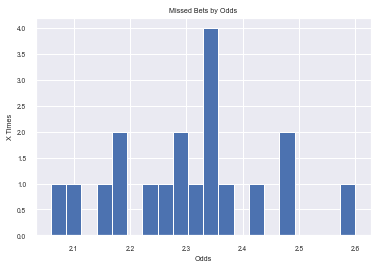

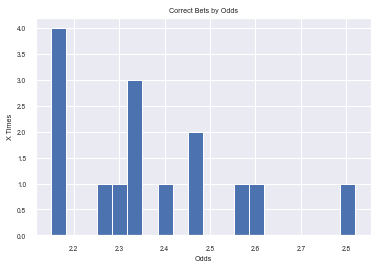

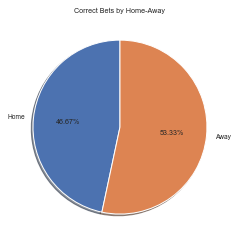

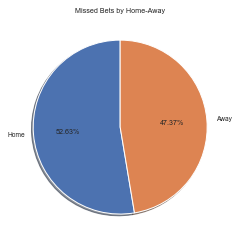

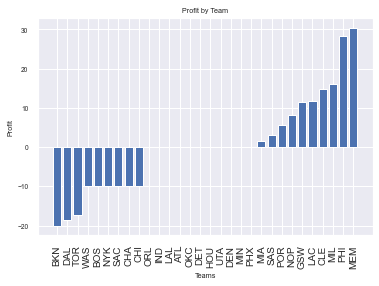

In [854]:
plot_hist('Missed Bets by Odds', 'Odds', 'X Times', missed_bets_odds)

plot_hist('Correct Bets by Odds', 'Odds', 'X Times', correct_bets_odds)

plot_pie_chart('Correct Bets by Home-Away', ['Home', 'Away'], correct_bets_home)

plot_pie_chart('Missed Bets by Home-Away', ['Home', 'Away'], missed_bets_home)

plot_bar('Profit by Team', 'Teams', 'Profit', money_by_team_labels, money_by_team_values)

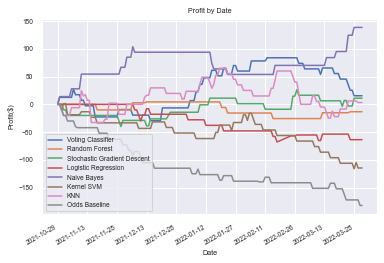

In [855]:
xpoints = money_by_date[:,0].astype(np.datetime64)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
for model in models_tracking:
    plt.plot(xpoints, model)
plt.plot(xpoints, bets_tracking_odds)

title = "Profit by Date"
plt.legend([x['model'] for x in results] + ['Odds Baseline'], loc='lower left')
plt.ylabel("Profit($)")
plt.xlabel("Date")
plt.title(title)
plt.gcf().autofmt_xdate()
plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
plt.show()